# 1- Class Activation Map with convolutions

In this firt part, we will code class activation map as described in the paper [Learning Deep Features for Discriminative Localization](http://cnnlocalization.csail.mit.edu/)

There is a GitHub repo associated with the paper:
https://github.com/zhoubolei/CAM

And even a demo in PyTorch:
https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py

The code below is adapted from this demo but we will not use hooks only convolutions...

As in the demo, we will use the Resnet18 architecture. In order to get CAM, we need to transform this network in a fully convolutional network: at all layers, we need to deal with images, i.e. with a shape $\text{Number of channels} \times W\times H$ . In particular, we are interested in the last images as shown here:
![](https://camo.githubusercontent.com/fb9a2d0813e5d530f49fa074c378cf83959346f7/687474703a2f2f636e6e6c6f63616c697a6174696f6e2e637361696c2e6d69742e6564752f6672616d65776f726b2e6a7067)

As we deal with a Resnet18 architecture, the image obtained before applying the `AdaptiveAvgPool2d` has size $512\times 7 \times 7$ if the input has size $3\times 224\times 224 $:
![resnet_Archi](https://pytorch.org/assets/images/resnet.png)



In [1]:
import io
import requests
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import cv2
import pdb
from matplotlib.pyplot import imshow


# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

In [2]:
net = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [3]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
x = torch.randn(5, 3, 224, 224)
y = net(x)
y.shape

torch.Size([5, 1000])

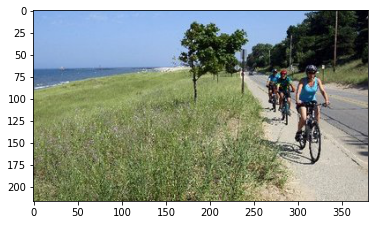

In [5]:
n_mean = [0.485, 0.456, 0.406]
n_std = [0.229, 0.224, 0.225]

normalize = transforms.Normalize(
   mean=n_mean,
   std=n_std
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

# Display the image we will use.
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
imshow(img_pil);

In [6]:
img_tensor = preprocess(img_pil)
net = net.eval()
logit = net(img_tensor.unsqueeze(0))

In [7]:
logit.shape

torch.Size([1, 1000])

In [8]:
img_tensor.shape

torch.Size([3, 224, 224])

In [ ]:
# download the imagenet category list
classes = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}


def print_preds(logit):
    # print the predicitions with their 'probabilities' from the logit
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

idx = print_preds(logit)

In [ ]:
def returnCAM(feature_conv, idx):
    # input: tensor feature_conv of dim 1000*W*H and idx between 0 and 999
    # output: image W*H with entries rescaled between 0 and 255 for the display
    cam = feature_conv[idx].detach().numpy()
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    return cam_img

In [ ]:
#some utilities
def pil_2_np(img_pil):
    # transform a PIL image in a numpy array
    return np.asarray(img_pil)

def display_np(img_np):
    imshow(Image.fromarray(np.uint8(img_np)))
    
def plot_CAM(img_np, CAM):
    height, width, _ = img_np.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img_np * 0.5
    display_np(result)

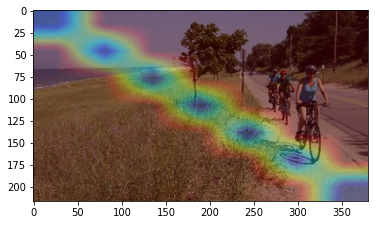

In [ ]:
# here is a fake example to see how things work
img_np = pil_2_np(img_pil)
diag_CAM = returnCAM(torch.eye(7).unsqueeze(0),0)
plot_CAM(img_np,diag_CAM)

In [ ]:
# your code here for your new network
resnet18_2 = models.resnet18(pretrained=True)
net_conv = nn.Sequential(*list(resnet18_2.children())[:-2])
# do not forget:
net_conv = net_conv.eval()

In [ ]:
print(net_conv)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# to test things are right
x = torch.randn(5, 3, 224, 224)
y = net_conv(x)
y.shape

torch.Size([5, 512, 7, 7])

In [ ]:
logit_conv = net_conv(img_tensor.unsqueeze(0))

In [ ]:
logit_conv.shape

torch.Size([1, 512, 7, 7])

In [ ]:
conv_weight=net.fc.weight.unsqueeze(-1).unsqueeze(-1)
conv_bias=net.fc.bias
output=F.conv2d(logit_conv, conv_weight, conv_bias)

In [ ]:
#transform this to [1,1000] tensor with AdaptativeAvgPool2d

logit_new=F.adaptive_avg_pool2d(output,output_size=(1,1)).squeeze(-1).squeeze(-1)
logit_new.shape

torch.Size([1, 1000])

In [ ]:
idx = print_preds(logit_new)

0.437 -> mountain bike, all-terrain bike, off-roader
0.131 -> alp
0.119 -> bicycle-built-for-two, tandem bicycle, tandem
0.108 -> unicycle, monocycle
0.049 -> lakeside, lakeshore


In [ ]:
m = nn.AdaptiveAvgPool2d((1,1000))
input = torch.randn(1, 64, 8, 9)
print(m(input).squeeze().shape)

torch.Size([64, 1000])


In [ ]:
logit_conv=output

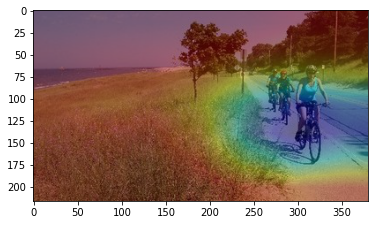

In [ ]:
i=0
CAM1 = returnCAM(logit_conv.squeeze(), idx[i])
plot_CAM(img_np,CAM1)

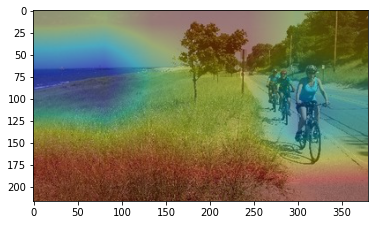

In [ ]:
i = 4
CAM2 = returnCAM(logit_conv.squeeze(),idx[i])
plot_CAM(img_np,CAM2)

# 2- Adversarial examples

In this second part, we will look at [adversarial examples](https://arxiv.org/abs/1607.02533): "An adversarial example is a sample of input data which has been modified very slightly in a way that is intended to cause a machine learning classifier to misclassify it. In many cases, these modifications can be so subtle that a human observer does not even notice the modification at all, yet the classifier still makes a mistake. Adversarial examples pose security concerns because they could be used to perform an attack on machine learning systems..."

Rules of the game:
- the attacker cannot modify the classifier, i.e. the neural net with the preprocessing done on the image before being fed to the network. 
- even if the attacker cannot modifiy the classifier, we assume that the attacker knows the architecture of the classifier. Here, we will still work with `resnet18` and the standard Imagenet normalization. 
- the attacker can only modify the physical image fed into the network.
- the attacker should fool the classifier, i.e. the label obtained on the corrupted image should not be the same as the label predicted on the original image.

First, you will implement *Fast gradient sign method (FGSM)* wich is described in Section 2.1 of [Adversarial examples in the physical world](https://arxiv.org/abs/1607.02533). The idea is simple, suppose you have an image $\mathbf{x}$ and when you pass it through the network, you get the 'true' label $y$. You know that your network has been trained by minimizing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ with respect to the parameters of the network $\theta$. Now, $\theta$ is fixed as you cannot modify the classifier so you need to modify $\mathbf{x}$. In order to do so, you can compute the gradient of the loss with respect to $\mathbf{x}$ i.e. $\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)$ and use it as follows to get the modified image $\tilde{\mathbf{x}}$:
$$
\tilde{\mathbf{x}} = \text{Clamp}\left(\mathbf{x} + \epsilon *
\text{sign}(\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)),0,1\right),
$$
where $\text{Clamp}(\cdot, 0,1)$ ensures that $\tilde{\mathbf{x}}$ is a proper image.
Note that if instead of sign, you take the full gradient, you are now following the gradient i.e. increasing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ so that $y$ becomes less likely to be the predicited label.

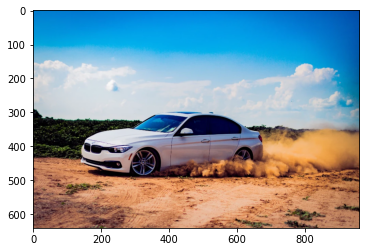

In [ ]:
# Image under attack!
url_car = 'https://cdn130.picsart.com/263132982003202.jpg?type=webp&to=min&r=640'
response = requests.get(url_car)
img_pil = Image.open(io.BytesIO(response.content))
imshow(img_pil);

In [ ]:
# same as above
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

for p in net.parameters():
    p.requires_grad = False
    
x = preprocess(img_pil).clone().unsqueeze(0)
logit = net(x)

In [ ]:
_ = print_preds(logit)

0.640 -> minivan
0.040 -> jeep, landrover
0.031 -> beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
0.020 -> minibus
0.019 -> pickup, pickup truck


In [ ]:
t_std = torch.from_numpy(np.array(n_std, dtype=np.float32)).view(-1, 1, 1)
t_mean = torch.from_numpy(np.array(n_mean, dtype=np.float32)).view(-1, 1, 1)

def plot_img_tensor(img):
    imshow(np.transpose(img.detach().numpy(), [1,2,0]))

def plot_untransform(x_t): 
    x_np = (x_t * t_std + t_mean).detach().numpy()
    x_np = np.transpose(x_np, [1, 2, 0])
    imshow(x_np)

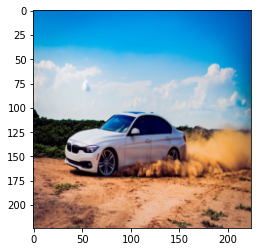

In [ ]:
# here we display an image given as a tensor
x_img = (x * t_std + t_mean).squeeze(0)
plot_img_tensor(x_img)

In [ ]:
# your implementation of the attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [ ]:
idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
x_img.requires_grad = True
logit = net(normalize(x_img).unsqueeze(0))
target = torch.tensor([idx])

#TODO: compute the loss to backpropagate
loss = criterion(logit, target)
net.zero_grad()
loss.backward()
_ = print_preds(logit)

0.640 -> minivan
0.040 -> jeep, landrover
0.031 -> beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
0.020 -> minibus
0.019 -> pickup, pickup truck


In [ ]:
# your attack here
data_grad = x_img.grad.data
epsilon = 0.01
x_att = fgsm_attack(x_img,epsilon,data_grad)

In [ ]:
# the new prediction for the corrupted image
logit = net(normalize(x_att).unsqueeze(0))
_ = print_preds(logit)

0.140 -> hay
0.095 -> thresher, thrasher, threshing machine
0.064 -> barrel, cask
0.054 -> projectile, missile
0.037 -> racer, race car, racing car


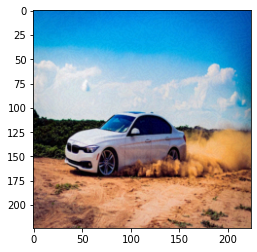

In [ ]:
# can you see the difference?
plot_img_tensor(x_att)

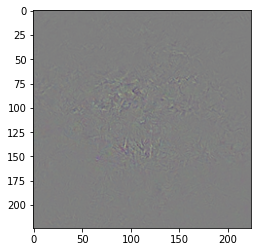

In [ ]:
# do not forget to plot the sign of the gradient
gradient = data_grad
plot_img_tensor((1+gradient)/2)

In [ ]:
# what is the prediction for the gradient? 
logit = net(normalize(gradient).unsqueeze(0))
_ = print_preds(logit)

0.099 -> spotlight, spot
0.086 -> matchstick
0.034 -> digital clock
0.024 -> lampshade, lamp shade
0.019 -> fountain


# 3- Transforming a car into a cat

We now implement the *Iterative Target Class Method (ITCM)* as defined by equation (4) in [Adversarial Attacks and Defences Competition](https://arxiv.org/abs/1804.00097)

To test it, we will transform the car (labeled minivan by our `resnet18`) into a [Tabby cat](https://en.wikipedia.org/wiki/Tabby_cat) (classe 281 in Imagenet). But you can try with any other target.

In [ ]:
x = preprocess(img_pil).clone()
xd = preprocess(img_pil).clone()
xd.requires_grad = True

In [ ]:
idx = 281 #tabby
optimizer = optim.SGD([xd], lr=0.01)
criterion = nn.CrossEntropyLoss()
target = torch.tensor([idx])
epsilon=0.01
alpha = 0.025
for i in range(200):
    #TODO: your code here
    output=net(xd.unsqueeze(0))
    loss = criterion(output, target)
    optimizer.zero_grad()
    loss.backward()
    x_grad = alpha * torch.sign(xd.grad.data)
    adv_temp = xd.data - x_grad
    total_grad = adv_temp - x
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    x_adv = xd + total_grad
    xd.data = x_adv
    optimizer.step()
    print(loss.item())
    
    new_idx = print_preds(output)
    print(i,'-----------------')
    
    # TODO: break the loop once we are satisfied 
    if new_idx[0]==idx:
        break

11.637317657470703
0.640 -> minivan
0.040 -> jeep, landrover
0.031 -> beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
0.020 -> minibus
0.019 -> pickup, pickup truck
0 -----------------
7.0450334548950195
0.059 -> barrel, cask
0.038 -> hay
0.037 -> minivan
0.032 -> seashore, coast, seacoast, sea-coast
0.024 -> sunscreen, sunblock, sun blocker
1 -----------------
2.9256370067596436
0.054 -> tabby, tabby cat
0.048 -> hay
0.021 -> chow, chow chow
0.018 -> Norwegian elkhound, elkhound
0.017 -> Egyptian cat
2 -----------------


In [ ]:
_ = print_preds(output)

0.054 -> tabby, tabby cat
0.048 -> hay
0.021 -> chow, chow chow
0.018 -> Norwegian elkhound, elkhound
0.017 -> Egyptian cat


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


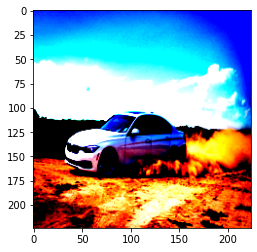

In [ ]:
# plot the corrupted image
plot_img_tensor(xd)

# 4- Where is the cat hidden?

Last, we use CAM to understand where the network see a cat in the image.

In [ ]:
logit2 = net_conv(xd.unsqueeze(0))

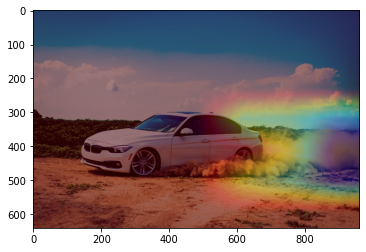

In [ ]:
img_np = pil_2_np(img_pil)
CAM1 = returnCAM(logit2.squeeze(), 281)
plot_CAM(img_np,CAM1)

In [ ]:
logit3 = net_conv(x.unsqueeze(0))

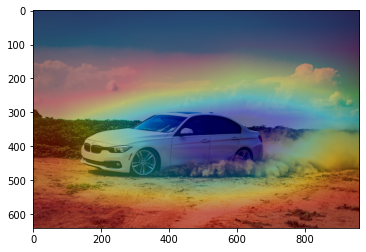

In [ ]:
img_np = pil_2_np(img_pil)
CAM1 = returnCAM(logit3.squeeze(), 0)
plot_CAM(img_np,CAM1)